In [2]:
import pandas as pd

Download PETA dataset using [link](https://www.dropbox.com/s/52ylx522hwbdxz6/PETA.zip?dl=0)

In [3]:
# carryingBabyBuggy - детская коляска
# carryingShoppingTro - продуктовая тележка
# carryingOther - что-то другое
# carryingFolder - папка с документами
# carryingPlasticBags - пластиковая пакет
# ----------------------------------------
# carryingBackpack - рюкзак
# carryingLuggageCase - Чемодан
# carryingMessengerBag - обычная сумка
# carryingSuitcase - офисный чемодан
# carryingNothing - 
requiredTags = ["carryingNothing", "carryingBackpack", "carryingMessengerBag", "carryingSuitcase", "carryingLuggageCase"]
requiredTags = ["carryingLuggageCase", "carryingSuitcase", "carryingMessengerBag", "carryingNothing", "carryingBackpack"]

In [ ]:
import os
print(os.getcwd())
files = os.listdir("PETA/PETA dataset/MIT/archive/")
[s for s in files if '00924' in s.lower()]

AttributeError: module 'os' has no attribute 'pwd'

In [4]:
import os
import pandas as pd
dirs = ["3DPeS", "CAVIAR4REID", "CUHK", "i-LID", "MIT", "PRID", "SARC3D", "TownCentre", "VIPeR"]

temp_table = []
for direct in dirs:
    f = open(f"PETA/PETA dataset/{direct}/archive/Label.txt")
    files = os.listdir(f"PETA/PETA dataset/{direct}/archive/")
    files.remove("Label.txt")
    for i in f:
        lst = i.split(" ")
        try: 

            filenames = [f"{direct}/archive/{s}" for s in files if int(s.replace(".png","").split("_")[0])==int(lst[0].replace(".png",""))]
            # print(lst[0], filenames)
            # if len(filenames)>1:
                # print(lst[0], filenames)
        except Exception as e:
            print(direct, lst[0])
            print(e)
            print("bad")
            continue
        
        temp_tag = [0]*len(requiredTags)
        for num_tag in range(len(requiredTags)):
            if requiredTags[num_tag] in lst:
                temp_tag[num_tag] = 1
                    # print(direct, lst[0])
                    # print(e)
                # print(lst)
        for filename in filenames:
            temp_table.append([filename]+temp_tag)

# print(temp_table)
df = pd.DataFrame(temp_table, columns=["Filename"]+requiredTags)
# df = df.drop_duplicates(subset="Filename", keep="first")
print(df.sum())
# df
print(df[df["Filename"].duplicated()]["Filename"].unique())
df
# df[df["Filename"]=="3DPeS/archive/74_488_FRAME_162_RGB.bmp"]
#
# carryingLuggageCase                                                    75
# carryingSuitcase                                                      108
# carryingMessengerBag                                                 1741
# carryingNothing                                                      2131
# carryingBackpack                                                     2327

Filename                3DPeS/archive/1_2_FRAME_104_RGB.bmp3DPeS/archi...
carryingLuggageCase                                                   335
carryingSuitcase                                                      145
carryingMessengerBag                                                 5166
carryingNothing                                                      4956
carryingBackpack                                                     3491
dtype: object
[]


,Filename,carryingLuggageCase,carryingSuitcase,carryingMessengerBag,carryingNothing,carryingBackpack
0,3DPeS/archive/1_2_FRAME_104_RGB.bmp,0,0,1,0,0
1,3DPeS/archive/1_1_FRAME_53_RGB.bmp,0,0,1,0,0
2,3DPeS/archive/1_4_FRAME_29_RGB.bmp,0,0,1,0,0
3,3DPeS/archive/1_2_FRAME_34_RGB.bmp,0,0,1,0,0
4,3DPeS/archive/1_1_FRAME_12_RGB.bmp,0,0,1,0,0
...,...,...,...,...,...,...
17720,VIPeR/archive/357_90_2.bmp,0,0,0,0,1
17721,VIPeR/archive/359_135_2.bmp,0,0,0,0,0
17722,VIPeR/archive/359_0_1.bmp,0,0,0,0,0
17723,VIPeR/archive/358_90_2.bmp,0,0,0,0,1


In [5]:
count = 0
for direct in dirs:
    f = open(f"PETA/PETA dataset/{direct}/archive/Label.txt")
    files = os.listdir(f"PETA/PETA dataset/{direct}/archive/")
    count += len(files)
print(count)

17734


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from PIL import Image
import pandas as pd
import os

In [7]:
class MultiLabelDataset(Dataset):
    def __init__(self, dataset, img_dir, transform=None):
        self.data = dataset
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.data.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')
        labels = torch.tensor(self.data.iloc[idx, 1:].values.astype('float32'))

        if self.transform:
            image = self.transform(image)
        
        return image, labels

In [8]:
loadedDataset = MultiLabelDataset(df, "PETA/PETA dataset/")
maxH = 0
maxW = 0
minH = 10000
minW = 10000

for i in range(len(loadedDataset)):
    size = loadedDataset[i][0].size
    if size[0] > maxW: maxW = size[0]
    if size[0] < minW: minW = size[0]
    if size[1] > maxH: maxH = size[1]
    if size[1] < minH: minH = size[1]
print(f"Min Size: {minW}, {minH}")
print(f"Max Size: {maxW}, {maxH}")


Min Size: 16, 39
Max Size: 272, 362


In [9]:
(272+16)/2, (362+39)/2

(144.0, 200.5)

In [10]:
class MultiLabelModel(nn.Module):
    def __init__(self, num_classes):
        super(MultiLabelModel, self).__init__()
        self.base_model = models.resnet18(pretrained=True)
        self.base_model.fc = nn.Linear(self.base_model.fc.in_features, num_classes)

    def forward(self, x):
        return self.base_model(x)  # logits (не через sigmoid!)

In [11]:
import copy
import datetime
import random
import traceback

import numpy as np
import torch
from torch.utils.data import DataLoader

In [12]:
# Функция инициализация сида рандомайзеров
def init_random_seed(value=0):
    random.seed(value)
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

# Функция копирования Тензоров на устройство вычисления
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))


def train_eval_loop(model, train_dataset, val_dataset, criterion,
                    lr=1e-4, epoch_n=10, batch_size=32,
                    device=None, early_stopping_patience=10, l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    dataloader_workers_n=0):
    """
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    # Выбор устройства для обучения модели
    if device is None:
        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    # Выбор оптимизатора
    if optimizer_ctor is None:
        # Если не выставлен, исползую Adam
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        # Иначе используй тот, что выставили
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    # Выбор регулятора скорости обучения
    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    # Загрузка обучающего датасета
    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    # Загрузка валидационного датасета
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    # Инициализация переменных "лучших" значений потерь и "лучшей" эпохи и модели
    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

    # По каждой эпохе
    for epoch_i in range(epoch_n):

        try:
            # Сохраняем время начала обучения эпохи
            epoch_start = datetime.datetime.now()
            print('Эпоха {}'.format(epoch_i))

            # Режим обучения модели
            model.train()
            mean_train_loss = 0
            train_batches_n = 0

            # Для каждого батча данных
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                # Если номер батча превысил количество батчей за эпоху, то завершаем
                if batch_i > max_batches_per_epoch_train:
                    break
                
                # Копируем батчи аргументов и ответов на устройство вычисления 
                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                # Создаем предсказание
                pred = model(batch_x)

                # Вычисляем отклонение
                loss = criterion(pred, batch_y)

                # Обнуляем градиент
                model.zero_grad()
                loss.backward()

                # Делаем шаг спуска
                optimizer.step()

                # Суммируем значения потери и считаем кол-во батчей
                mean_train_loss += float(loss)
                train_batches_n += 1
            
            # Считаем среднюю потерю за обучение
            mean_train_loss /= train_batches_n

            # Выводим информацию об эпохе

            # print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n,
            #                                                (datetime.datetime.now() - epoch_start).total_seconds()))
            print(f'Эпоха: {train_batches_n} итераций, {(datetime.datetime.now() - epoch_start).total_seconds():0.2f} сек')
            print(f'Среднее значение функции потерь на обучении {mean_train_loss}')

            # Режим валидации модели
            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            # С отключенным вычислением градиента
            with torch.no_grad():
                # Для каждого батча валидации 
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break
                    
                    # Копируем батчи аргументов и ответов на устройство вычисления                     
                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    # Создаем предсказание
                    pred = model(batch_x)
    
                    # Вычисляем отклонение
                    loss = criterion(pred, batch_y)

                    # Суммируем значения потери и считаем кол-во батчей
                    mean_val_loss += float(loss)
                    val_batches_n += 1

            # Считаем среднюю потерю за обучение
            mean_val_loss /= val_batches_n
            print(f'Среднее значение функции потерь на валидации {mean_val_loss}')

            # Если средняя потеря валидации меньше лучшей
            if mean_val_loss < best_val_loss:
                # То сохраняем номер эпохи
                best_epoch_i = epoch_i
                # То значение потери
                best_val_loss = mean_val_loss
                # То сохраняем модель
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель!')
            # Иначе если модель не улучшилась через несколько эпох
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print(f'Модель не улучшилась за последние {early_stopping_patience} эпох, прекращаем обучение')
                # То останвливаем обучение
                break
            # Для существующего регулятора скорости обучения
            if lr_scheduler is not None:
                # Регулируем скорость
                lr_scheduler.step(mean_val_loss)
            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break

    return best_val_loss, best_model

def predict_with_model(model, dataset, device=None, batch_size=32, num_workers=0, return_labels=False):
    """
    :param model: torch.nn.Module - обученная модель
    :param dataset: torch.utils.data.Dataset - данные для применения модели
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :return: numpy.array размерности len(dataset) x *
    """
    # Определяем устройство
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Инициализируем результаты батчей
    results_by_batch = []

    device = torch.device(device)
    # Загружаем модель на устройство
    model.to(device)
    # И переводим в режим валидации
    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    labels = []

    # С отключенным вычислением градиента
    with torch.no_grad():
        import tqdm
        # Для каждого батча
        for batch_x, batch_y in tqdm.tqdm(dataloader, total=len(dataset)/batch_size):
            
            # Копируем батч на устройство
            batch_x = copy_data_to_device(batch_x, device)

            # Если нужно вернуть названия классов
            if return_labels:
                labels.append(batch_y.numpy())

            # Делаем предсказание
            batch_pred = model(batch_x)

            # Добавляем результаты в массив
            results_by_batch.append(batch_pred.detach().cpu().numpy())
    # Если нужно вернуть названия классов
    if return_labels:
        return np.concatenate(results_by_batch, 0), np.concatenate(labels, 0)
    else:
        return np.concatenate(results_by_batch, 0)


In [13]:
# Преобразования изображения
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

init_random_seed(0)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# Сперва отделим тестовую часть (например, 20%)
train_val_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

# Затем от оставшегося возьмём валидацию (например, 20% от train+val)
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=0)

# Загрузка данных
train_dataset = MultiLabelDataset(train_df, "PETA/PETA dataset/", transform=transform)

val_dataset = MultiLabelDataset(val_df, "PETA/PETA dataset/", transform=transform)

test_dataset = MultiLabelDataset(test_df, "PETA/PETA dataset/", transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

In [14]:
# Гиперпараметры
num_classes = len(requiredTags)
model = MultiLabelModel(num_classes)

/home/nikosolov/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nikosolov/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [15]:
train_eval_loop(model=model, 
                train_dataset=train_dataset, 
                val_dataset=val_dataset, 
                criterion=nn.BCEWithLogitsLoss(),
                lr=1e-4, 
                epoch_n=15, 
                batch_size=100,
                device="cuda:0" if torch.cuda.is_available() else "cpu", 
                early_stopping_patience=8, 
                l2_reg_alpha=0,
                max_batches_per_epoch_train=1000,
                max_batches_per_epoch_val=500,
                data_loader_ctor=DataLoader,
                optimizer_ctor=None,
                lr_scheduler_ctor=None,
                shuffle_train=True,
                dataloader_workers_n=0)

Эпоха 0
Эпоха: 114 итераций, 24.45 сек
Среднее значение функции потерь на обучении 0.3535636528803591
Среднее значение функции потерь на валидации 0.2458406943699409
Новая лучшая модель!

Эпоха 1
Эпоха: 114 итераций, 23.22 сек
Среднее значение функции потерь на обучении 0.1467446418184983
Среднее значение функции потерь на валидации 0.22273219916327247
Новая лучшая модель!

Эпоха 2
Эпоха: 114 итераций, 23.51 сек
Среднее значение функции потерь на обучении 0.05945644929612938
Среднее значение функции потерь на валидации 0.2344543712920156

Эпоха 3
Эпоха: 114 итераций, 23.43 сек
Среднее значение функции потерь на обучении 0.02278686822963911
Среднее значение функции потерь на валидации 0.2499937589826255

Эпоха 4
Эпоха: 114 итераций, 22.71 сек
Среднее значение функции потерь на обучении 0.011044300835285532
Среднее значение функции потерь на валидации 0.2605872005224228

Эпоха 5
Эпоха: 114 итераций, 23.15 сек
Среднее значение функции потерь на обучении 0.0064068088520383626
Среднее значе

(0.22273219916327247,
 MultiLabelModel(
   (base_model): ResNet(
     (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
     (layer1): Sequential(
       (0): BasicBlock(
         (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
         (relu): ReLU(inplace=True)
         (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       )
       (1): BasicBlock(
         (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
         (bn1): BatchNorm2d(6

In [16]:
T = 0
F = 0
for sample in test_dataset:
    images = sample[0].to(device).unsqueeze(0)
    images
    outputs = model(images)
    # print(outputs)
    preds = torch.sigmoid(outputs)
    # print(preds)
    binary_preds = (preds > 0.5).int()
    # print(binary_preds)
    # print(sample[1])
    if torch.all(binary_preds == sample[1].to(device).unsqueeze(0)):
        T += 1
    else:
        F += 1
print(T, F, T/len(test_dataset))

2377 1168 0.6705218617771509


In [17]:
from sklearn.metrics import f1_score, precision_score, recall_score
import torch

model.eval()

all_preds = []
all_labels = []
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.sigmoid(outputs)

        preds = (probs > 0.5).int()  # бинаризация

        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())

# Объединяем все батчи
all_preds = torch.cat(all_preds).numpy()
all_labels = torch.cat(all_labels).numpy()

# print(all_preds)
# print(all_labels)

# Вычисляем метрики
f1 = f1_score(all_labels, all_preds, average='macro')
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')

print(f"F1-score:     {f1:.4f}")
print(f"Precision:    {precision:.4f}")
print(f"Recall:       {recall:.4f}")

F1-score:     0.5931
Precision:    0.7226
Recall:       0.5573


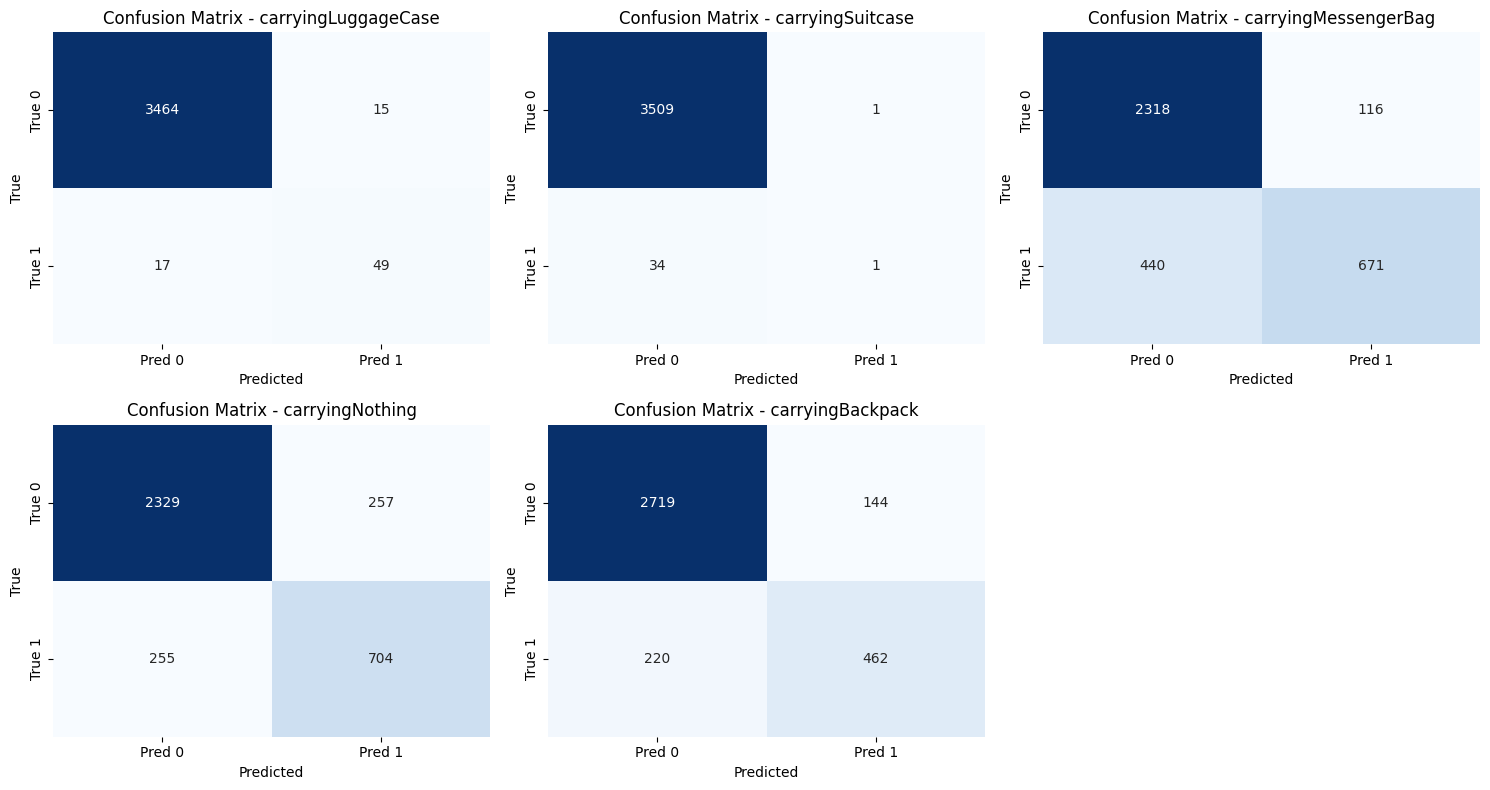

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Допустим, у тебя 5 классов:
class_names = requiredTags
num_classes = len(class_names)

# Создаем subplot-сетку (например, 2 строки × 3 столбца)
cols = 3
rows = (num_classes + cols - 1) // cols  # округление вверх
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))

# Убедимся, что axes — это 2D-массив
axes = axes.flatten()

for i in range(num_classes):
    cm = confusion_matrix(all_labels[:, i], all_preds[:, i])
    ax = axes[i]

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["Pred 0", "Pred 1"], yticklabels=["True 0", "True 1"], ax=ax)
    ax.set_title(f"Confusion Matrix - {class_names[i]}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

# Отключим лишние пустые графики, если классов меньше чем subplots
for j in range(num_classes, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [19]:
# Сохранение модели
torch.jit.script(model).save('bagsai_model.pt')
# # Загрузка модели без прописывания класса модели
# model = torch.jit.load('model_scripted.pt').eval()

In [20]:
torch.Tensor([])

tensor([])